# <b>CS156 (Introduction to AI), Fall 2021</b>
# <u><b>Homework 8 submission</b></u>

### Roster Name: Nand Kishore Khuswaha
### Student ID: 013920192
### Email address: nandkishore.khuswaha@sjsu.edu
Any special notes or anything you would like to communicate to me about this homework submission goes in here.

##  <u>References and sources </u>

List all your references and sources here.
This includes all sites/discussion boards/blogs/posts/etc. where you grabbed some code examples.

##  <u>Solution</u>

#### Load libraries and set random number generator seed

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import itertools




In [4]:
np.random.seed(42)

#### Code the solution

In [5]:
# load training, validation and test images,
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "./flowers/training",
    validation_split=0.2,
    labels='inferred',
    label_mode='categorical',
    subset="training",
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "./flowers/training",
    validation_split=0.2,
    labels='inferred',
    label_mode='categorical',
    subset="validation",
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "./flowers/test",
    labels='inferred',
    label_mode='categorical',
    seed=42,
    image_size=image_size,
    batch_size=1,
)

Found 3456 files belonging to 5 classes.
Using 2765 files for training.
Found 3456 files belonging to 5 classes.
Using 691 files for validation.
Found 861 files belonging to 5 classes.


In [7]:
# Data augmentation
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

/Users/becoming1/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


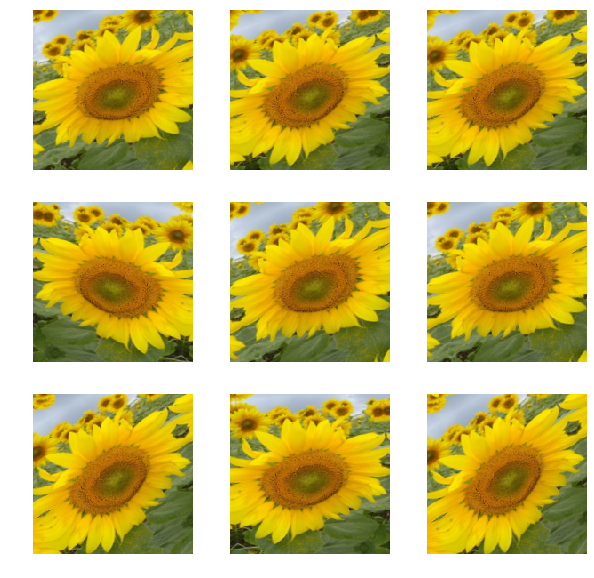

In [8]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(20):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [9]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes= 5 )

#keras.utils.plot_model(model, show_shapes=True)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 180, 180, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 180, 180, 3)  0           sequential[0][0]                 
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 90, 90, 32)   896         rescaling[0][0]                  
______________________________________________________________________________________________

In [10]:
# training model
epochs = 10

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/10
87/87 [==============================] - 1736s 20s/step - loss: 1.2310 - accuracy: 0.5262 - val_loss: 1.7119 - val_accuracy: 0.2590


/Users/becoming1/anaconda3/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
87/87 [==============================] - 9128s 106s/step - loss: 1.0458 - accuracy: 0.6192 - val_loss: 2.1426 - val_accuracy: 0.2590
Epoch 3/10
87/87 [==============================] - 13258s 154s/step - loss: 0.8870 - accuracy: 0.6749 - val_loss: 2.8376 - val_accuracy: 0.2590
Epoch 4/10
87/87 [==============================] - 9377s 109s/step - loss: 0.8675 - accuracy: 0.6759 - val_loss: 3.3331 - val_accuracy: 0.2590
Epoch 5/10
87/87 [==============================] - 6151s 71s/step - loss: 0.7958 - accuracy: 0.7027 - val_loss: 4.0389 - val_accuracy: 0.2590
Epoch 6/10
87/87 [==============================] - 291s 3s/step - loss: 0.7182 - accuracy: 0.7302 - val_loss: 2.0828 - val_accuracy: 0.3372
Epoch 7/10
87/87 [==============================] - 287s 3s/step - loss: 0.7069 - accuracy: 0.7418 - val_loss: 0.9292 - val_accuracy: 0.6585
Epoch 8/10
87/87 [==============================] - 277s 3s/step - loss: 0.6222 - accuracy: 0.7700 - val_loss: 1.9697 - val_accuracy: 0.5210
E

In [13]:
predicted_labels = []
true_labels =  []
for x, y in test_ds:
    pred= model.predict(x)
    true_labels.append(np.where(y == 1)[1][0])
    predicted_labels.append(np.where(pred == np.amax(pred))[1][0])
    
    


In [14]:
cm = tf.math.confusion_matrix(labels=true_labels, predictions=predicted_labels).numpy() 
class_labels = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


In [11]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

    

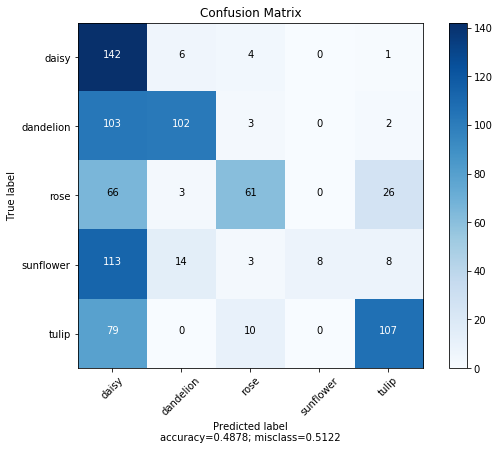

In [15]:
# confusion matrix
# It seems my model predicted fairly bad because it seems 10 epoc 
# is not enough to train my model, on the other hand training 20 epoc 
# takes very long
plot_confusion_matrix(cm, 
                      normalize    = False,
                      target_names = class_labels,
                      title        = "Confusion Matrix")